In [1]:
from modules.utils import load_yaml, save_yaml, get_logger
from modules.earlystoppers import EarlyStopper
from modules.recorders import Recorder
from modules.trainer import Trainer
from modules.optimizers import get_optimizer
from modules.schedulers import PolyLR
from models.utils import get_model, EMA

import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from PIL import Image
from PIL import ImageFilter
import random
import torch.utils.data.sampler as sampler
import torchvision.transforms as transforms
import torchvision.transforms.functional as transforms_f

from datetime import datetime, timezone, timedelta
import numpy as np
import pandas as pd
import random
import os
import copy
from glob import glob
import matplotlib.pyplot as plt

c:\Users\Admin\anaconda3\envs\imgseg\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# Root directory
PROJECT_DIR = os.path.join('./')

# Load config
config_path = os.path.join(PROJECT_DIR, 'config', 'train_config.yml')
config = load_yaml(config_path)
predict_config = load_yaml(os.path.join(PROJECT_DIR, 'config', 'predict_config.yml'))

# Train Serial
kst = timezone(timedelta(hours=9))
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")

# Recorder directory
RECORDER_DIR = os.path.join(PROJECT_DIR, 'results', 'train', train_serial)
os.makedirs(RECORDER_DIR, exist_ok=True)

# Data directory
DATA_DIR = os.path.join(PROJECT_DIR, 'data', config['DIRECTORY']['dataset'])

# Seed
torch.manual_seed(config['TRAINER']['seed'])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(config['TRAINER']['seed'])
random.seed(config['TRAINER']['seed'])

# GPU
os.environ['CUDA_VISIBLE_DEVICES'] = str(config['TRAINER']['gpu'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [24]:
DATA_DIR

'../data'

In [16]:
# --------------------------------------------------------------------------------
# Define data augmentation
# --------------------------------------------------------------------------------
def transform(image, label=None, logits=None, crop_size=(512, 512), scale_size=(0.8, 1.0), augmentation=True) :
    image = transforms_f.resize(image, (385, 513), Image.BILINEAR)
    if label is not None :
        label = transforms_f.resize(label, (385, 513), Image.NEAREST)
    if logits is not None :
        logits = transforms_f.resize(logits, (385, 513), Image.NEAREST)

    # Random rescale image
    raw_w, raw_h = image.size
    scale_ratio = random.uniform(scale_size[0], scale_size[1])  # random scale size (0.8<= i <= 1.0)

    resized_size = (int(raw_h * scale_ratio), int(raw_w * scale_ratio))
    # Add padding if rescaled image size is less than crop size
    if crop_size == - 1 :   
        crop_size = (raw_h, raw_w)  # use original image size without crop or padding

    # if crop_size is larger than resized_size : "Apply padding to resized image"
    if crop_size[0] > resized_size[0] or crop_size[1] > resized_size[1] :
        right_pad, bottom_pad = max(crop_size[1] - resized_size[1], 0), max(crop_size[0] - resized_size[0], 0)
        image = transforms_f.pad(image, padding=(0, 0, right_pad, bottom_pad), padding_mode='reflect')
        if label is not None :
            label = transforms_f.pad(label, padding=(0, 0, right_pad, bottom_pad), fill=255, padding_mode='constant')
        if logits is not None :
            logits = transforms_f.pad(logits, padding=(0, 0, right_pad, bottom_pad), fill=0, padding_mode='constant')

    # Random Cropping
    i, j, h, w = transforms.RandomCrop.get_params(image, output_size=crop_size)
    image = transforms_f.crop(image, i, j, h, w)
    if label is not None :
        label = transforms_f.crop(label, i, j, h, w)
    if logits is not None :
        logits = transforms_f.crop(logits, i, j, h, w)


    if augmentation :
        # Random horizontal flipping
        if torch.rand(1) > 0.5 :
            image = transforms_f.hflip(image)
            if label is not None :
                label = transforms_f.hflip(label)
            if logits is not None :
                logits = transforms_f.hflip(logits)
        
        if torch.rand(1) > 0.5 :
            image = transforms_f.vflip(image)
            if label is not None :
                label = transforms_f.vflip(label)
            if logits is not None :
                logits = transforms_f.vflip(logits)

        if torch.rand(1) > 0.5 :
            image = transforms_f.rotate(image, 90, resample=Image.NEAREST)
            if label is not None :
                label = transforms_f.rotate(label, 90, resample=Image.NEAREST)
            if logits is not None :
                logits = transforms_f.rotate(logits, 90, resample=Image.NEAREST)

                
        # Random color jitter
        if torch.rand(1) > 0.2:
            color_transform = transforms.ColorJitter((0.75, 1.25), (0.75, 1.25), (0.75, 1.25), (-0.25, 0.25))  # For PyTorch 1.9/TorchVision 0.10 users
            #color_transform = transforms.ColorJitter.get_params((0.75, 1.25), (0.75, 1.25), (0.75, 1.25), (-0.25, 0.25))
            image = color_transform(image)


        # Random Gaussian fillter
        if torch.rand(1) > 0.5 :
            sigma = random.uniform(0.15, 1.15)
            image = image.filter(ImageFilter.GaussianBlur(radius=sigma))

    # Transform to tensor
    image = transforms_f.to_tensor(image)
    if label is not None :
        label = (transforms_f.to_tensor(label) * 255).long()
        label[label == 255] = -1    # invalid pixels are re-mapped to index - 1
    if logits is not None :
        logits = transforms_f.to_tensor(logits)
    
    # Apply(ImageNet) normalization
    image = transforms_f.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    # def transforms return
    if logits is not None :
        return image, label, logits
    else :
        return image, label

def denormalise(x, imagenet=True):
    if imagenet:
        x = transforms_f.normalize(x, mean=[0., 0., 0.], std=[1 / 0.229, 1 / 0.224, 1 / 0.225])
        x = transforms_f.normalize(x, mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
        return x
    else:
        return (x + 1) / 2

def tensor_to_pil(im, label, logits):
    im = denormalise(im)
    im = transforms_f.to_pil_image(im.cpu())

    label = label.float() / 255.
    label = transforms_f.to_pil_image(label.unsqueeze(0).cpu())

    logits = transforms_f.to_pil_image(logits.unsqueeze(0).cpu())
    return im, label, logits

def batch_transform(data, label, logits, crop_size, scale_size, apply_augmentation):
    data_list, label_list, logits_list = [], [], []
    device = data.device

    for k in range(data.shape[0]):
        data_pil, label_pil, logits_pil = tensor_to_pil(data[k], label[k], logits[k])
        aug_data, aug_label, aug_logits = transform(data_pil, label_pil, logits_pil,
                                                    crop_size=crop_size,
                                                    scale_size=scale_size,
                                                    augmentation=apply_augmentation)
        data_list.append(aug_data.unsqueeze(0))
        label_list.append(aug_label)
        logits_list.append(aug_logits)

    data_trans, label_trans, logits_trans = \
        torch.cat(data_list).to(device), torch.cat(label_list).to(device), torch.cat(logits_list).to(device)
    return data_trans, label_trans, logits_trans



In [17]:
class BuildDataLoader_t:
    def __init__(self, num_labels, dataset_path, batch_size):
        self.data_path = dataset_path
        self.im_size = [513, 513]
        self.crop_size = [450, 450]
        self.num_segments = 5
        self.scale_size = (0.9, 0.9) # default: (0.5, 1.5)
        self.batch_size = batch_size
        self.train_l_idx, self.valid_l_idx = get_harbor_idx(self.data_path, train=True, is_label=True, label_num=num_labels)
        self.train_u_idx = get_harbor_idx(self.data_path, train=True, is_label=False)
        self.test_idx = get_harbor_idx(self.data_path, train=False)

        if num_labels == 0:  # using all data
            self.train_l_idx = self.train_u_idx

    def build(self, supervised=False):
        train_l_dataset = BuildDataset_t(self.data_path, self.train_l_idx,
                                       crop_size=self.crop_size, scale_size=self.scale_size,
                                       augmentation=True, train=True, is_label=True)
        train_u_dataset = BuildDataset_t(self.data_path, self.train_u_idx,
                                       crop_size=self.crop_size, scale_size=(1.0, 1.0),
                                       augmentation=False, train=True, is_label=False)
        valid_l_dataset = BuildDataset_t(self.data_path, self.valid_l_idx,
                                       crop_size=self.crop_size, scale_size=self.scale_size,
                                       augmentation=False, train=True, is_label=True)
        test_dataset    = BuildDataset_t(self.data_path, self.test_idx,
                                       crop_size=self.im_size, scale_size=(1.0, 1.0),
                                       augmentation=False, train=False, is_label=True)

        if supervised:  # no unlabelled dataset needed, double batch-size to match the same number of training samples
            self.batch_size = self.batch_size * 2

        num_samples = self.batch_size * 200  # for total 40k iterations with 200 epochs
        # num_samples = self.batch_size * 2
        train_l_loader = torch.utils.data.DataLoader(
            train_l_dataset,
            batch_size=self.batch_size,
            sampler=sampler.RandomSampler(data_source=train_l_dataset,
                                          replacement=True,
                                          num_samples=num_samples),
            drop_last=True,)


        valid_l_loader = torch.utils.data.DataLoader(
            valid_l_dataset,
            batch_size=self.batch_size,
            sampler=sampler.RandomSampler(data_source=valid_l_dataset,
                                          replacement=True,
                                          num_samples=num_samples),
            drop_last=True,)

        if not supervised:
            train_u_loader = torch.utils.data.DataLoader(
                train_u_dataset,
                batch_size=self.batch_size,
                sampler=sampler.RandomSampler(data_source=train_u_dataset,
                                              replacement=True,
                                              num_samples=num_samples),
                drop_last=True,)

        test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
        )
        if supervised:
            return train_l_loader, valid_l_loader, test_loader
        else:
            return train_l_loader, train_u_loader, valid_l_loader, test_loader


In [18]:
class BuildDataset_t(Dataset):
    def __init__(self, root, idx_list, crop_size=(512, 512), scale_size=(0.5, 2.0),
                 augmentation=True, train=True, is_label=True):
        self.root = os.path.expanduser(root)
        self.train = train
        self.crop_size = crop_size
        self.augmentation = augmentation
        self.idx_list = idx_list
        self.scale_size = scale_size
        self.is_label = is_label

    def __getitem__(self, index):
        if self.train:
            idx_filename = self.idx_list[index].split('\\')[-1]
            print(idx_filename)
            if self.is_label:
                image_root = Image.open(self.root + f'/train/labeled_images/{idx_filename}'+'.jpg')
                label_root = Image.open(self.root + f'/train/labels/{idx_filename}' + '.png')
            else:
                image_root = Image.open(self.root + f'/train/unlabeled_images/{idx_filename}' + '.jpg')
                label_root = None

            image, label = transform(image_root, label_root, None, self.crop_size, self.scale_size, self.augmentation)
            if label is not None:
                return image, label.squeeze(0)
            else:
                return image

        else:
            file_name = f'{idx_filename}.jpg'
            image_root = Image.open(self.root + f'/test/images/{file_name}')
            image, label = transform(image_root, None, None, self.crop_size, self.scale_size, self.augmentation)
            return image, torch.tensor(image_root.size), file_name

    def __len__(self):
        return len(self.idx_list)


In [19]:
def get_harbor_idx(root, train=True, is_label=True ,label_num=15):
    if train:
        if is_label:
            classes = ['background', 'container_truck', 'forklift', 'reach_stacker', 'ship']
            image_path = glob(os.path.join(root, 'train', 'labeled_images', '*.jpg'))
            image_idx_list = list(map(lambda x : x.split('/')[-1].split('.')[0], image_path))
            train_idx = []
            valid_idx = []
            for c in classes:
                matched_idx = [i for i in image_idx_list if c in i]
                train_idx.extend(matched_idx[label_num:])
                valid_idx.extend(matched_idx[:label_num])
            return train_idx, valid_idx
        else:
            image_path = glob(os.path.join(root, 'train', 'unlabeled_images', '*.jpg'))
            train_idx = list(map(lambda x: x.split('/')[-1].split('.')[0], image_path))
            return train_idx
    else:
        image_path = glob(os.path.join(root, 'test', 'images', '*.jpg'))
        test_idx = list(map(lambda x: x.split('/')[-1].split('.')[0], image_path))
        return test_idx

In [25]:
data_loader = BuildDataLoader_t(5, DATA_DIR, 5)
train_l_loader, train_u_loader, valid_l_loader, _ = data_loader.build(supervised=False)

In [26]:
print(len(data_loader.train_l_idx))
print(len(data_loader.valid_l_idx))

115
20


In [27]:
train_l = iter(train_l_loader)
train_u = iter(train_u_loader)

In [28]:
train_l_data, train_l_label = train_l.next()
train_u_data= train_u.next()

container_truck_NWUG26aUDC
container_truck_GZ5iv0qzJW
ship_gGqVZmTukg


c:\Users\Admin\anaconda3\envs\imgseg\lib\site-packages\torchvision\transforms\functional.py:404: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\imgseg\lib\site-packages\torchvision\transforms\functional.py:984: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


forklift_Frgr7uhGI5
forklift_e5KECvHV7E
reach_stacker_3uLbp1Iszl
ship_BAS5tFzXSJ
ship_LqK8LEP9xZ
reach_stacker_lW2Q1Xko60
ship_ueGj0vhKl9


ship_I6D37ltQKd
ship_LasmyzeDfR
forklift_hCKHFKLZwR
ship_LasmyzeDfR
ship_YhVg3zqznL


C:\Users\Admin\AppData\Local\Temp\ipykernel_13524\2960207114.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(train_l_data).shape)


torch.Size([5, 3, 450, 450])


<function matplotlib.pyplot.show(close=None, block=None)>

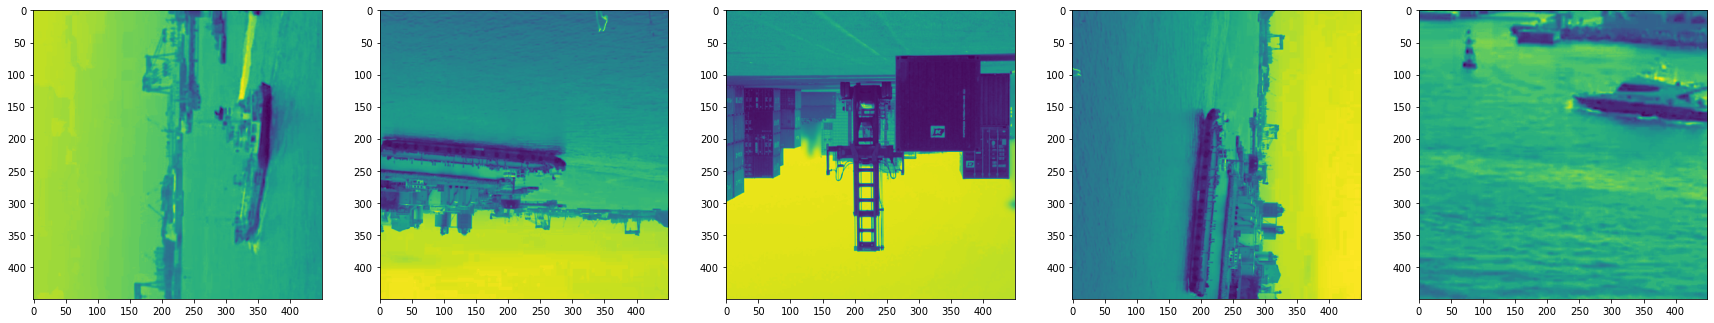

In [29]:
train_l_data, train_l_label = train_l.next()
print(torch.tensor(train_l_data).shape)
plt.figure(figsize=(30, 15))
for i in range(5):
    sub = 151+i
    plt.subplot(sub)
    plt.imshow(train_l_data[i][0])
plt.show


In [32]:
train_l_label[1]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [33]:
sub = pd.read_csv('C:/submissionfile/06180_022014.csv')
sub.drop(981, axis=0, inplace=True)
sub

,file_name,class,prediction
0,013ddVCiF0.jpg,ship,107 24 132 2 319 34 531 40 746 42 963 41 1005 ...
1,017LqtrIcn.jpg,ship,3301 4 3432 4 3440 6 3450 2 3571 22 3710 24 38...
2,01IWVfCAgM.jpg,ship,48217 16 48710 23 49204 27 49698 31 50192 35 5...
3,01JG3czzUQ.jpg,ship,40496 6 40742 22 40989 30 41238 36 41488 40 41...
4,01k2Nvf9O0.jpg,ship,16117 6 16382 24 16656 32 16932 38 17207 45 17...
...,...,...,...
8404,zyQV1kdrTO.jpg,ship,79843 6 80417 38 80468 10 80996 67 81576 72 82...
8405,zyng4w2wxJ.jpg,ship,31540 8 31896 14 32253 20 32611 24 32969 28 33...
8406,zz23hE2RUF.jpg,ship,70444 10 70910 14 71375 19 71840 23 72306 27 7...
8407,zzFUpJUoj7.jpg,ship,19472 7 19717 13 19963 17 20209 20 20455 24 20...


In [48]:
files = sub['file_name']
imgs = [transforms.ToTensor()(plt.imread(os.path.join(DATA_DIR, 'test', 'images', file))) for file in files]

In [ ]:
#load image
img = Image.open()

In [50]:
imgs[0].shape

torch.Size([3, 216, 216])

In [47]:
print(imgs[0].shape)

plt.figure(figsize=(30, 30))
plt.imshow(imgs[3])
plt.show

ValueError: pic should be 2/3 dimensional. Got 1 dimensions.

In [ ]:
overay = 

In [31]:
import torch.nn.functional as F

img = Image.open('C:/Users/Admin/OneDrive/C Documents/GitHub/aivill_seg/dataset/train/labeled_images').convert("RGB")
target = Image.open('C:/Users/Admin/OneDrive/C Documents/GitHub/aivill_seg/dataset/train/labels')
img_norm = img.unsqueeze(0).cuda()

num_classes = 5
colors_base = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128]
]

categories_base = [
    'background',
    'container_truck',
    'forklift',
    'reach_stacker',
    'ship'
]

enc = DeepLab

x4, x1 = enc(img_norm)
cls_output = dec(x4, x1)

F.interpolate(cls_output, size = img_norm.size())

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Admin/OneDrive/C Documents/GitHub/aivill_seg/dataset/train/labeled_images'

torch.Size([5, 3, 450, 450])


<function matplotlib.pyplot.show(close=None, block=None)>

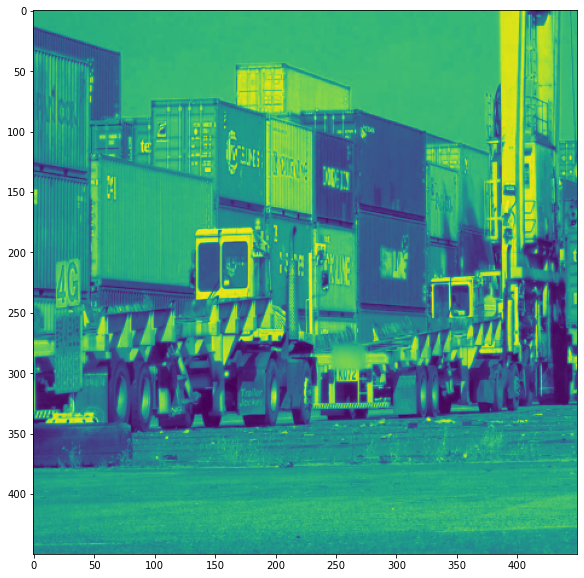

In [ ]:
t_u_data = torch.Tensor(train_u_data)
print(t_u_data.shape)
plt.figure(figsize=(15, 10))
plt.imshow(t_u_data[1][0])
plt.show

In [ ]:
t_l_data = torch.Tensor(train_l_data[0])
print(torch.Tensor(train_l_data[0]).shape)
print(train_l_data[1][0])

torch.Size([3, 450, 450])
tensor([[ 0.2796,  0.2796,  0.2796,  ...,  0.5193,  0.5193,  0.5193],
        [ 0.2796,  0.2796,  0.2796,  ...,  0.5193,  0.5193,  0.5193],
        [ 0.2453,  0.2453,  0.2453,  ...,  0.5193,  0.5193,  0.5193],
        ...,
        [-0.5424, -0.5424, -0.5424,  ..., -0.2684, -0.2684, -0.2684],
        [-0.5424, -0.5424, -0.5424,  ..., -0.2684, -0.2684, -0.2684],
        [-0.5424, -0.5424, -0.5424,  ..., -0.2856, -0.2856, -0.2856]])
